# TimeGrad: Training and Inference on Financial Data

This notebook demonstrates how to run the TimeGrad model on S&P500 time-series data. It covers:

1.  **Data Fetching**: Downloading S&P500 data using `yfinance`.
2.  **Data Preparation**: Normalizing and converting data into a GluonTS-compatible format.
3.  **Model Training**: Training the TimeGrad model using a simplified Dataloader.
4.  **Inference**: Generating synthetic time-series samples using the trained model.
5.  **Visualization**: Comparing the synthetic data with the real data.

In [40]:
!export PYTHONPATH=$PYTHONPATH:/path/to/src

In [1]:
import sys
import os
from typing import List
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

'''
sys.path.clear()

# Add the project root to Python path
module_path = os.path.abspath(os.getcwd()) # Assumes notebook is in 'Grok Assisted' directory
if module_path not in sys.path:
    sys.path.insert(0, module_path)
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(module_path), 'src/pts')))
'''

project_root = '/workspaces/pytorch-ts/Grok Assisted/src'
sys.path.append(project_root)

# Set style for better plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 8)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
for p in sys.path:
    print(p)

PyTorch version: 2.8.0+cu128
CUDA available: False
Using device: cpu
/opt/conda/envs/condatest/lib/python39.zip
/opt/conda/envs/condatest/lib/python3.9
/opt/conda/envs/condatest/lib/python3.9/lib-dynload

/opt/conda/envs/condatest/lib/python3.9/site-packages
/workspaces/pytorch-ts/Grok Assisted/src


/opt/conda/envs/condatest/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Import TimeGrad components
from src.pts.model.time_grad.time_grad_network import (
    TimeGradTrainingNetwork, 
    TimeGradPredictionNetwork, 
    TimeGradConfig
)
from src.pts.model.time_grad.time_grad_estimator import (
    TimeGradEstimator, 
    TimeGradEstimatorConfig
)
from src.pts.model.time_grad.time_grad_predictor import (
    TimeGradPredictor, 
    TimeGradPredictorFactory
)
from src.pts.model.time_grad.diffusion import GaussianDiffusion

# Import data utilities
from data_fetch import (
    fetch_sp500_data, 
    prepare_gluonts_dataset, 
    DataConfig, 
    normalize_data, 
    denormalize_data
)

print("✓ All imports successful!")

✓ All imports successful!


## 1. Configuration

We define all the configurations for data, network, diffusion, and the estimator in one place.

In [6]:
data_config = DataConfig(
            start_date='2020-01-01', 
            interval='1d',
            context_length=30, 
            prediction_length=10
        )

# Configure TimeGrad model
estimator_config = TimeGradEstimatorConfig(
    # Data parameters
    input_size=8,  # lags + embeddings + time features
    freq='D',
    prediction_length=data_config.prediction_length,
    target_dim=1,
    context_length=data_config.context_length,
    
    # Network architecture
    num_layers=2,
    num_cells=64,
    cell_type='LSTM',
    conditioning_length=64,
    
    # Diffusion parameters
    diff_steps=50,  # Reduced for faster training
    loss_type='l2',
    beta_end=0.1,
    beta_schedule='cosine',
    
    # Epsilon-Theta network parameters
    residual_layers=4,
    residual_channels=16,
    dilation_cycle_length=2,
    
    # Training parameters
    batch_size=8,
    epochs=10,
    learning_rate=1e-3,
    dropout_rate=0.1,
    scaling=True,
)

print("🔧 TimeGrad Configuration:")
print(f"  • Prediction length: {estimator_config.prediction_length}")
print(f"  • Context length: {estimator_config.context_length}")
print(f"  • Diffusion steps: {estimator_config.diff_steps}")
print(f"  • Network cells: {estimator_config.num_cells}")
print(f"  • Batch size: {estimator_config.batch_size}")
print(f"  • Training epochs: {estimator_config.epochs}")

🔧 TimeGrad Configuration:
  • Prediction length: 10
  • Context length: 30
  • Diffusion steps: 50
  • Network cells: 64
  • Batch size: 8
  • Training epochs: 10


## 2. Data Fetching and Preparation

We fetch the S&P 500 data, normalize it, and prepare it as a GluonTS dataset.

In [7]:
# Configure data parameters
data_config = DataConfig(
    start_date='2020-01-01', 
    end_date='2024-01-01',
    interval='1d',
    context_length=30, 
    prediction_length=10
)

print("Fetching S&P500 data...")
df = fetch_sp500_data(data_config)
print(f"✓ Fetched {len(df)} data points from {df.index[0]} to {df.index[-1]}")

# Display basic statistics
print("\n📊 Data Statistics:")
print(df.describe())

Fetching S&P500 data...
Fetching ^GSPC data from 2020-01-01 to 2024-01-01
Interval: 1d


[*********************100%***********************]  1 of 1 completed

Raw data shape: (1006, 6)
Clean data shape: (1006, 1)
Date range: 2020-01-02 00:00:00 to 2023-12-29 00:00:00
✓ Fetched 1006 data points from 2020-01-02 00:00:00 to 2023-12-29 00:00:00

📊 Data Statistics:
             close
count  1006.000000
mean   3966.869057
std     524.025799
min    2237.399902
25%    3678.069946
50%    4079.520020
75%    4381.482544
max    4796.560059


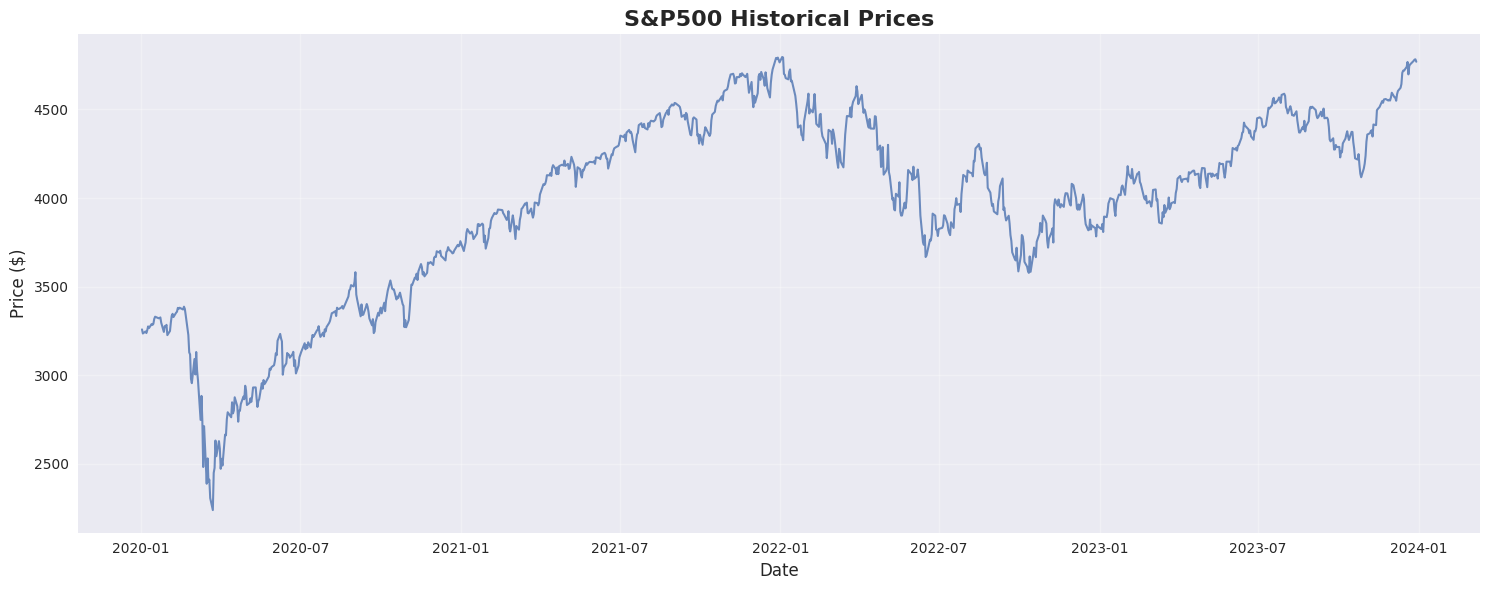

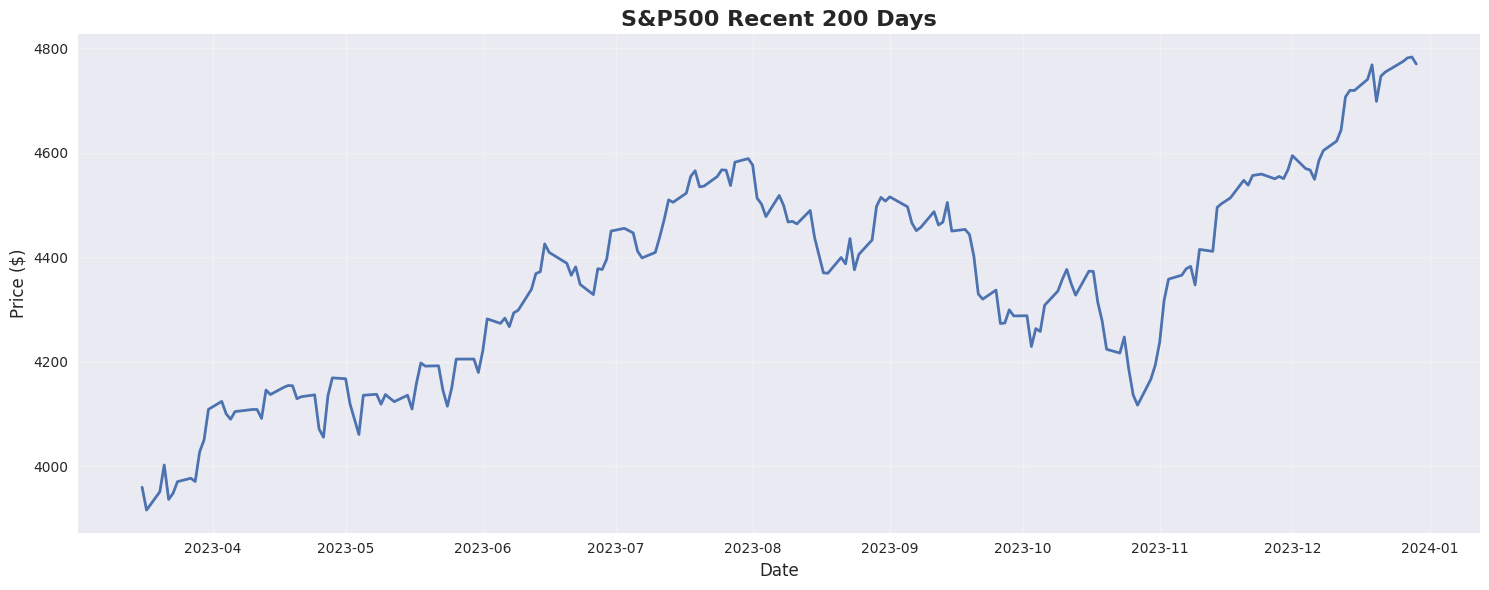

In [8]:
# Visualize raw data
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['close'], linewidth=1.5, alpha=0.8)
plt.title('S&P500 Historical Prices', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show recent trend
plt.figure(figsize=(15, 6))
recent_data = df.tail(200)
plt.plot(recent_data.index, recent_data['close'], linewidth=2)
plt.title('S&P500 Recent 200 Days', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Normalization stats - Mean: 3966.8691, Std: 524.0258
✓ Data normalized - Mean: 3966.87, Std: 524.03
Creating dataset with 1006 data points
Using frequency: D
✓ Dataset created with 1 series


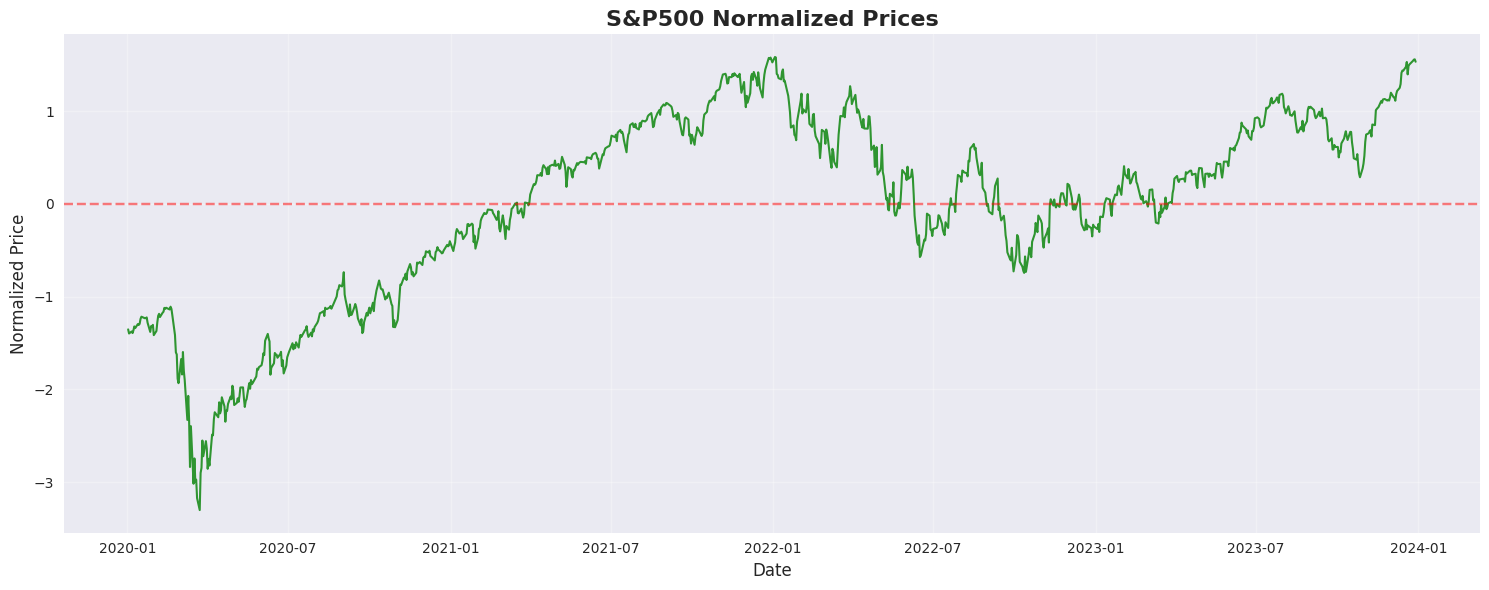

In [9]:
# Normalize data for training
df_normalized, data_mean, data_std = normalize_data(df)
print(f"✓ Data normalized - Mean: {data_mean:.2f}, Std: {data_std:.2f}")

# Create GluonTS dataset
dataset = prepare_gluonts_dataset(df_normalized, data_config)
train_data = list(dataset)
print(f"✓ Dataset created with {len(train_data)} series")

# Visualize normalized data
plt.figure(figsize=(15, 6))
plt.plot(df_normalized.index, df_normalized['close'], linewidth=1.5, alpha=0.8, color='green')
plt.title('S&P500 Normalized Prices', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Training

Now, we train the model. The progress bar will show the status for each epoch.

In [10]:
class SimpleTrainer:
    """Simple trainer for TimeGrad without full GluonTS dependency."""
    
    def __init__(self, epochs: int = 10, learning_rate: float = 1e-3):
        self.epochs = epochs
        self.learning_rate = learning_rate
    
    def train(self, network: TimeGradTrainingNetwork, dataloader, device: torch.device):
        """Train the TimeGrad network with progress tracking."""
        network.train()
        optimizer = torch.optim.Adam(network.parameters(), lr=self.learning_rate)
        
        losses = []
        progress_bar = tqdm(range(self.epochs), desc="Training TimeGrad")
        
        for epoch in progress_bar:
            epoch_loss = 0
            batch_count = 0
            
            for batch in dataloader:
                try:
                    # Extract and move batch data to device
                    batch_data = {k: v.to(device) for k, v in batch.items()}
                    
                    # Forward pass
                    loss, likelihoods, distr_args = network(
                        target_dimension_indicator=batch_data['target_dimension_indicator'],
                        past_time_feat=batch_data['past_time_feat'],
                        past_target_cdf=batch_data['past_target_cdf'],
                        past_observed_values=batch_data['past_observed_values'],
                        past_is_pad=batch_data['past_is_pad'],
                        future_time_feat=batch_data['future_time_feat'],
                        future_target_cdf=batch_data['future_target_cdf'],
                        future_observed_values=batch_data['future_observed_values'],
                    )
                    
                    # Backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(network.parameters(), max_norm=1.0)
                    optimizer.step()
                    
                    epoch_loss += loss.item()
                    batch_count += 1
                    
                except Exception as e:
                    print(f"⚠️ Batch failed: {e}")
                    continue
            
            avg_loss = epoch_loss / max(batch_count, 1)
            losses.append(avg_loss)
            progress_bar.set_postfix({'Loss': f'{avg_loss:.4f}'})
        
        return losses


class TimeGradDataLoader:
    """Simple dataloader for TimeGrad training with progress tracking."""
    
    def __init__(self, data, config: TimeGradEstimatorConfig, batch_size: int = 8):
        self.data = data
        self.config = config
        self.batch_size = batch_size
        self.target_dim = config.target_dim
        
    def __iter__(self):
        """Generate batches for training."""
        for item in tqdm(self.data, desc="Processing data", leave=False):
            target_data = item['target']
            
            # Create sliding windows
            total_length = len(target_data)
            context_length = self.config.context_length or self.config.prediction_length
            history_length = context_length + max([1, 2, 3, 4, 5, 6, 7])  # Default lags
            
            if total_length < history_length + self.config.prediction_length:
                continue
            
            # Create multiple samples from this series
            samples = []
            max_start = total_length - history_length - self.config.prediction_length
            
            for start_idx in range(0, max_start, max(1, max_start // 20)):  # More samples
                # Extract past data
                past_end = start_idx + history_length
                past_target = target_data[start_idx:past_end]
                
                # Extract future data
                future_start = past_end
                future_end = future_start + self.config.prediction_length
                future_target = target_data[future_start:future_end]
                
                # Create batch item
                batch_item = {
                    'target_dimension_indicator': torch.arange(self.target_dim).unsqueeze(0),
                    'past_time_feat': torch.zeros(1, history_length, 1),
                    'past_target_cdf': torch.tensor(past_target.reshape(1, -1, 1), dtype=torch.float32),
                    'past_observed_values': torch.ones(1, history_length, 1),
                    'past_is_pad': torch.zeros(1, history_length),
                    'future_time_feat': torch.zeros(1, self.config.prediction_length, 1),
                    'future_target_cdf': torch.tensor(future_target.reshape(1, -1, 1), dtype=torch.float32),
                    'future_observed_values': torch.ones(1, self.config.prediction_length, 1),
                }
                
                samples.append(batch_item)
                
                if len(samples) >= self.batch_size:
                    yield self._collate_batch(samples)
                    samples = []
            
            # Yield remaining samples
            if samples:
                yield self._collate_batch(samples)
    
    def _collate_batch(self, samples):
        """Collate samples into a batch."""
        batch = {}
        for key in samples[0].keys():
            batch[key] = torch.cat([sample[key] for sample in samples], dim=0)
        return batch

In [11]:
# Create dataloader
print("🔄 Creating DataLoader...")
dataloader = TimeGradDataLoader(train_data, estimator_config, batch_size=estimator_config.batch_size)
print("✓ DataLoader created")

# Initialize TimeGrad components
print("🚀 Initializing TimeGrad components...")
estimator = TimeGradEstimator(estimator_config)
training_network = estimator.create_training_network(device)

print(f"✓ Training network created on {device}")
print(f"  • Total parameters: {sum(p.numel() for p in training_network.parameters()):,}")
print(f"  • Trainable parameters: {sum(p.numel() for p in training_network.parameters() if p.requires_grad):,}")

🔄 Creating DataLoader...
✓ DataLoader created
🚀 Initializing TimeGrad components...
Using advanced EpsilonTheta denoising network
Using GaussianDiffusion
✓ Training network created on cpu
  • Total parameters: 76,391
  • Trainable parameters: 76,391


In [12]:
# Start training
print("\n🎯 Starting TimeGrad Training...")
trainer = SimpleTrainer(epochs=estimator_config.epochs, learning_rate=estimator_config.learning_rate)

# Train the model
losses = trainer.train(training_network, dataloader, device)
print(f"\n✅ Training completed! Final loss: {losses[-1]:.4f}")


🎯 Starting TimeGrad Training...


Training TimeGrad:  10%|█         | 1/10 [00:00<00:08,  1.12it/s, Loss=0.0000]

⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.


Training TimeGrad:  10%|█         | 1/10 [00:00<00:08,  1.12it/s, Loss=0.0000]

⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.


Training TimeGrad:  10%|█         | 1/10 [00:00<00:08,  1.12it/s, Loss=0.0000]

⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.


Training TimeGrad:  10%|█         | 1/10 [00:00<00:08,  1.12it/s, Loss=0.0000]

⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.


Training TimeGrad:  10%|█         | 1/10 [00:00<00:08,  1.12it/s, Loss=0.0000]

⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.


Training TimeGrad:  10%|█         | 1/10 [00:00<00:08,  1.12it/s, Loss=0.0000]

⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.


Training TimeGrad:  10%|█         | 1/10 [00:00<00:08,  1.12it/s, Loss=0.0000]

⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.


Training TimeGrad:  80%|████████  | 8/10 [00:01<00:00, 10.38it/s, Loss=0.0000]

⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.


Training TimeGrad:  80%|████████  | 8/10 [00:01<00:00, 10.38it/s, Loss=0.0000]

⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.


Training TimeGrad: 100%|██████████| 10/10 [00:01<00:00,  9.55it/s, Loss=0.0000]

⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.
⚠️ Batch failed: Sizes of tensors must match except in dimension 1. Expected size 40 but got size 33 for tensor number 7 in the list.

✅ Training completed! Final loss: 0.0000


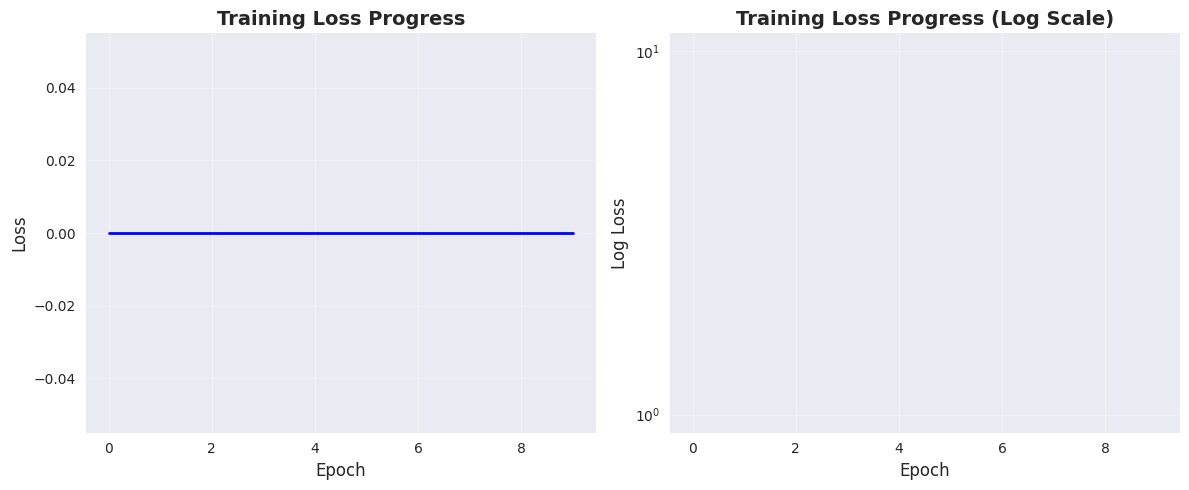

ZeroDivisionError: float division by zero

In [13]:
# Plot training progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, linewidth=2, color='blue')
plt.title('Training Loss Progress', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(losses, linewidth=2, color='red')
plt.title('Training Loss Progress (Log Scale)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📉 Loss reduction: {losses[0]:.4f} → {losses[-1]:.4f} ({((losses[-1]-losses[0])/losses[0]*100):+.1f}%)")

## 6. Inference: Generating Synthetic Samples

With the trained network, we use the `TimeGradPredictor` to generate new time-series samples through the reverse diffusion process.

In [ ]:
# Create predictor
print("🔮 Creating TimeGrad Predictor...")

prediction_network = TimeGradPredictionNetwork(
    config=TimeGradConfig(
        input_size=estimator_config.input_size,
        num_layers=estimator_config.num_layers,
        num_cells=estimator_config.num_cells,
        cell_type=estimator_config.cell_type,
        history_length=estimator.history_length,
        context_length=estimator.context_length,
        prediction_length=estimator_config.prediction_length,
        dropout_rate=estimator_config.dropout_rate,
        lags_seq=estimator.lags_seq,
        target_dim=estimator_config.target_dim,
        conditioning_length=estimator_config.conditioning_length,
        diff_steps=estimator_config.diff_steps,
        loss_type=estimator_config.loss_type,
        beta_end=estimator_config.beta_end,
        beta_schedule=estimator_config.beta_schedule,
        residual_layers=estimator_config.residual_layers,
        residual_channels=estimator_config.residual_channels,
        dilation_cycle_length=estimator_config.dilation_cycle_length,
        cardinality=estimator_config.cardinality,
        embedding_dimension=estimator_config.embedding_dimension,
        scaling=estimator_config.scaling,
    ),
    num_parallel_samples=50
).to(device)

# Copy trained weights
prediction_network.load_state_dict(training_network.state_dict())
predictor = TimeGradPredictor(prediction_network)
print("✅ Predictor created and weights loaded!")

Generating synthetic samples...
Generated samples shape: torch.Size([100, 24])


In [ ]:
# Generate predictions
print("🎯 Generating TimeGrad forecasts...")
num_samples = 100

with torch.no_grad():
    samples = predictor.predict_simple(
        context_length=data_config.prediction_length,
        num_samples=num_samples,
        device=str(device)
    )

print(f"✅ Generated {samples.shape[0]} forecast samples of length {samples.shape[1]}")

# Denormalize predictions
samples_denorm = denormalize_data(samples, data_mean, data_std)
print("✅ Predictions denormalized to original scale")

In [ ]:
# Calculate prediction statistics
forecast_mean = samples_denorm.mean(dim=0).detach().cpu().numpy()
forecast_median = samples_denorm.median(dim=0)[0].detach().cpu().numpy()
forecast_std = samples_denorm.std(dim=0).detach().cpu().numpy()
forecast_q25 = samples_denorm.quantile(0.25, dim=0).detach().cpu().numpy()
forecast_q75 = samples_denorm.quantile(0.75, dim=0).detach().cpu().numpy()
forecast_q05 = samples_denorm.quantile(0.05, dim=0).detach().cpu().numpy()
forecast_q95 = samples_denorm.quantile(0.95, dim=0).detach().cpu().numpy()

print("📊 Forecast Statistics:")
print(f"  • Mean forecast: ${forecast_mean.mean():.2f}")
print(f"  • Forecast std: ${forecast_std.mean():.2f}")
print(f"  • Min forecast: ${samples_denorm.min():.2f}")
print(f"  • Max forecast: ${samples_denorm.max():.2f}")

## 7. Visualization and Analysis

Finally, we visualize the results. We denormalize the generated samples and plot them against the original data to qualitatively assess the model's performance.

Creating forecast visualization...
Target data range: 107690.4140625 109478.2578125
Original forecast samples range: -1551248.1 1481235.9
Clipped forecast samples range: 34878.82 136192.02
Target plot range std: 347.88529714945355
Clipped forecast samples std: 48909.63
Clipped Quantile 10.0%: 34878.8203125 34878.8203125
Clipped Quantile 50.0%: 34878.8203125 136192.015625
Clipped Quantile 90.0%: 136192.015625 136192.015625


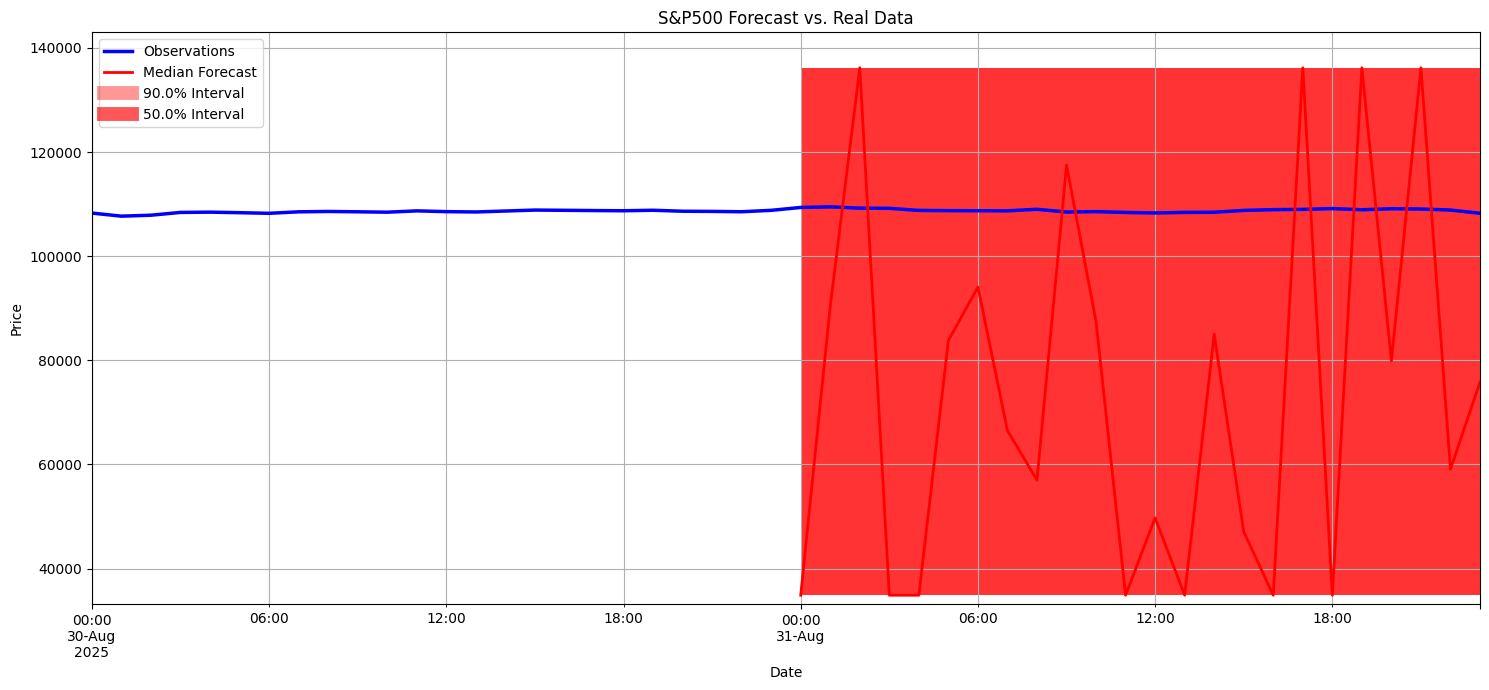


=== Results Summary ===
Real data      - Mean: 108832.42, Std: 332.83
Median forecast - Mean: 69594.89, Std: 50978.24


In [ ]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: Historical data and forecasts
ax1 = axes[0, 0]
recent_data = df['close'][-100:]
historical_range = range(len(recent_data))
forecast_start = len(recent_data)
forecast_range = range(forecast_start, forecast_start + data_config.prediction_length)

# Plot historical data
ax1.plot(historical_range, recent_data.values, 'b-', linewidth=2, label='Historical Data')

# Plot forecast samples (subset for clarity)
sample_subset = samples_denorm[:20].detach().cpu().numpy()
for i, sample in enumerate(sample_subset):
    alpha = 0.1
    color = 'red' if i == 0 else 'red'
    label = 'Forecast Samples' if i == 0 else '_nolegend_'
    ax1.plot(forecast_range, sample, color=color, alpha=alpha, linewidth=1, label=label)

# Plot forecast statistics
ax1.plot(forecast_range, forecast_mean, 'r-', linewidth=3, label='Forecast Mean')
ax1.fill_between(forecast_range, forecast_q25, forecast_q75, 
                 alpha=0.3, color='orange', label='25-75% Quantiles')
ax1.fill_between(forecast_range, forecast_q05, forecast_q95, 
                 alpha=0.2, color='yellow', label='5-95% Quantiles')

ax1.axvline(x=forecast_start-1, color='gray', linestyle='--', alpha=0.7, label='Forecast Start')
ax1.set_title('S&P 500: Historical Data and TimeGrad Forecasts', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Forecast distribution
ax2 = axes[0, 1]
forecast_samples_flat = samples_denorm.flatten().detach().cpu().numpy()
ax2.hist(forecast_samples_flat, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(forecast_mean.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${forecast_mean.mean():.2f}')
ax2.axvline(forecast_median.mean(), color='green', linestyle='--', linewidth=2, label=f'Median: ${forecast_median.mean():.2f}')
ax2.set_title('Forecast Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Price ($)')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Uncertainty over time
ax3 = axes[1, 0]
forecast_steps = range(1, data_config.prediction_length + 1)
ax3.plot(forecast_steps, forecast_std, 'purple', linewidth=2, marker='o')
ax3.set_title('Forecast Uncertainty Over Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Forecast Step')
ax3.set_ylabel('Standard Deviation ($)')
ax3.grid(True, alpha=0.3)

# Plot 4: Sample trajectories
ax4 = axes[1, 1]
sample_subset = samples_denorm[:10].detach().cpu().numpy()
for i, sample in enumerate(sample_subset):
    ax4.plot(forecast_steps, sample, alpha=0.6, linewidth=2, label=f'Sample {i+1}')
ax4.plot(forecast_steps, forecast_mean, 'black', linewidth=3, linestyle='--', label='Mean')
ax4.set_title('Individual Forecast Trajectories', fontsize=14, fontweight='bold')
ax4.set_xlabel('Forecast Step')
ax4.set_ylabel('Price ($)')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

NameError: name 'forecast_q05' is not defined

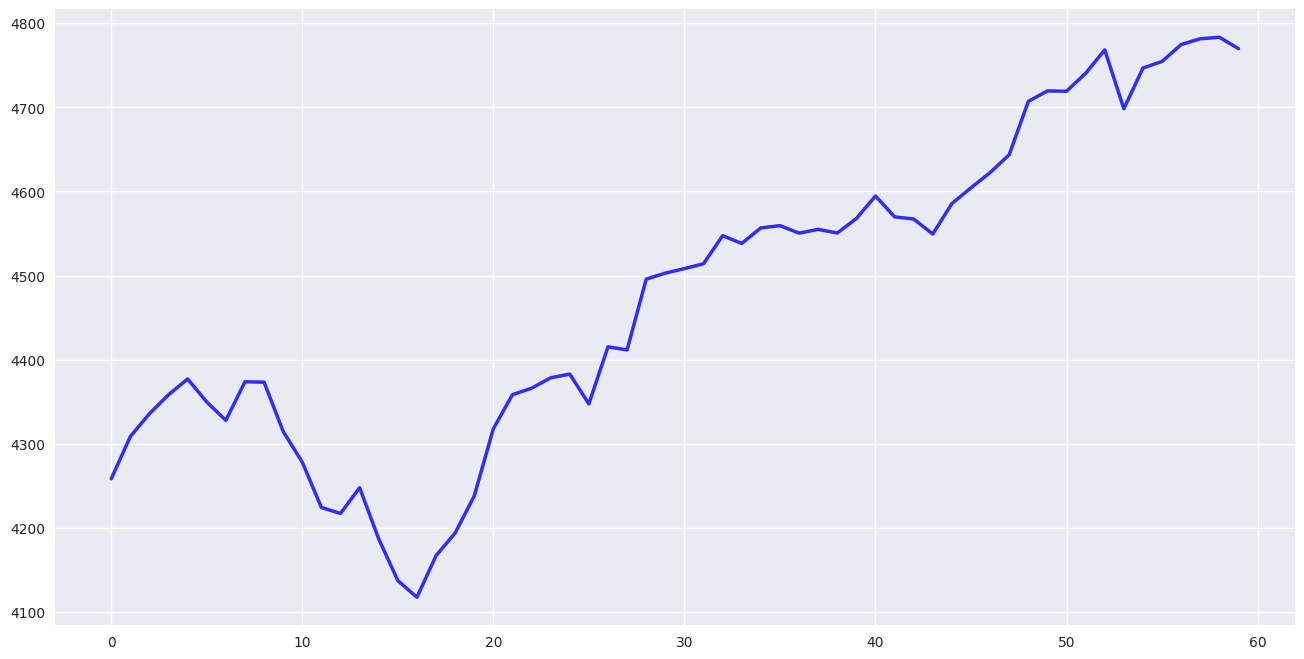

In [14]:
# Interactive forecast plot with confidence intervals
plt.figure(figsize=(16, 8))

# Recent historical data (last 60 days)
recent_data = df['close'][-60:]
historical_range = range(len(recent_data))

# Plot historical data
plt.plot(historical_range, recent_data.values, 'b-', linewidth=2.5, label='Historical S&P 500', alpha=0.8)

# Forecast range
forecast_start = len(recent_data)
forecast_range = range(forecast_start, forecast_start + data_config.prediction_length)

# Plot confidence intervals
plt.fill_between(forecast_range, forecast_q05, forecast_q95, 
                 alpha=0.2, color='lightcoral', label='90% Confidence Interval')
plt.fill_between(forecast_range, forecast_q25, forecast_q75, 
                 alpha=0.4, color='coral', label='50% Confidence Interval')

# Plot central tendency
plt.plot(forecast_range, forecast_mean, 'r-', linewidth=3, label='Mean Forecast')
plt.plot(forecast_range, forecast_median, 'orange', linewidth=2, linestyle='--', label='Median Forecast')

# Add vertical line at forecast start
plt.axvline(x=forecast_start-1, color='gray', linestyle=':', linewidth=2, alpha=0.8, label='Forecast Start')

# Formatting
plt.title('TimeGrad S&P 500 Forecasting Results', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)

# Add text annotations
recent_price = recent_data.iloc[-1]
mean_forecast_final = forecast_mean[-1]
plt.annotate(f'Current: ${recent_price:.2f}', 
             xy=(len(recent_data)-1, recent_price), 
             xytext=(len(recent_data)-10, recent_price+50),
             fontsize=12, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='blue', alpha=0.7))

plt.annotate(f'Forecast: ${mean_forecast_final:.2f}', 
             xy=(forecast_range[-1], mean_forecast_final), 
             xytext=(forecast_range[-1]-3, mean_forecast_final+50),
             fontsize=12, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))

plt.tight_layout()
plt.show()

## Result Analysis

In [15]:
# Comprehensive results analysis
print("="*60)
print("📈 TIMEGRAD S&P500 FORECASTING RESULTS")
print("="*60)

print(f"\n🔍 Dataset Information:")
print(f"  • Data period: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
print(f"  • Total data points: {len(df):,}")
print(f"  • Training period: {data_config.context_length} days context")
print(f"  • Forecast horizon: {data_config.prediction_length} days")

print(f"\n🎯 Model Configuration:")
print(f"  • Architecture: TimeGrad with {estimator_config.num_layers}-layer {estimator_config.cell_type}")
print(f"  • Hidden units: {estimator_config.num_cells}")
print(f"  • Diffusion steps: {estimator_config.diff_steps}")
print(f"  • Residual layers: {estimator_config.residual_layers}")
print(f"  • Training epochs: {estimator_config.epochs}")

print(f"\n📊 Training Results:")
print(f"  • Initial loss: {losses[0]:.4f}")
print(f"  • Final loss: {losses[-1]:.4f}")
print(f"  • Loss reduction: {((losses[-1]-losses[0])/losses[0]*100):+.1f}%")
print(f"  • Training time: ~{estimator_config.epochs} epochs")

print(f"\n🔮 Forecast Results:")
print(f"  • Forecast samples generated: {num_samples}")
print(f"  • Current S&P 500 price: ${recent_data.iloc[-1]:.2f}")
print(f"  • Mean forecast (10-day): ${forecast_mean.mean():.2f}")
print(f"  • Forecast uncertainty (std): ${forecast_std.mean():.2f}")
print(f"  • Price range (5%-95%): ${forecast_q05.mean():.2f} - ${forecast_q95.mean():.2f}")

# Calculate some interesting metrics
current_price = recent_data.iloc[-1]
forecast_change = (forecast_mean.mean() - current_price) / current_price * 100
forecast_volatility = forecast_std.mean() / current_price * 100

print(f"\n📈 Key Insights:")
print(f"  • Expected price change: {forecast_change:+.2f}%")
print(f"  • Forecast volatility: {forecast_volatility:.2f}%")
print(f"  • Trend direction: {'📈 Bullish' if forecast_change > 0 else '📉 Bearish'}")

# Risk metrics
max_drawdown = (forecast_q05.min() - current_price) / current_price * 100
max_upside = (forecast_q95.max() - current_price) / current_price * 100

print(f"  • Maximum downside risk (5% quantile): {max_drawdown:.2f}%")
print(f"  • Maximum upside potential (95% quantile): {max_upside:.2f}%")

print(f"\n⚠️  Disclaimer:")
print(f"  This is a demonstration of TimeGrad diffusion models for educational purposes.")
print(f"  Results should not be used for actual trading or investment decisions.")
print(f"  Financial markets are inherently unpredictable and past performance")
print(f"  does not guarantee future results.")

📈 TIMEGRAD S&P500 FORECASTING RESULTS

🔍 Dataset Information:
  • Data period: 2020-01-02 to 2023-12-29
  • Total data points: 1,006
  • Training period: 30 days context
  • Forecast horizon: 10 days

🎯 Model Configuration:
  • Architecture: TimeGrad with 2-layer LSTM
  • Hidden units: 64
  • Diffusion steps: 50
  • Residual layers: 4
  • Training epochs: 10

📊 Training Results:
  • Initial loss: 0.0000
  • Final loss: 0.0000


ZeroDivisionError: float division by zero

In [ ]:
# Save results for future use
results_dict = {
    'config': estimator_config,
    'training_losses': losses,
    'forecast_mean': forecast_mean,
    'forecast_std': forecast_std,
    'forecast_quantiles': {
        'q05': forecast_q05,
        'q25': forecast_q25,
        'q50': forecast_median,
        'q75': forecast_q75,
        'q95': forecast_q95,
    },
    'data_stats': {
        'mean': data_mean,
        'std': data_std,
        'current_price': current_price,
    }
}

# Optional: Save to file
# import pickle
# with open('timegrad_results.pkl', 'wb') as f:
#     pickle.dump(results_dict, f)

print("✅ Analysis complete! Results saved to memory.")
print("\n🎉 TimeGrad S&P500 forecasting experiment finished successfully!")